In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
from PINN import PINN, get_loss

In [2]:
# Read excel with multiple sheets
xls = pd.ExcelFile('data/correct_data.xlsx')
df = xls.parse('BR01')
columns = ['Time', 'Biomass', 'Glucose']
df.columns = columns

t_train = df['Time'].values
u_train = df[['Biomass', 'Glucose']].values

In [3]:
pinn = PINN(1, 2, T_START=df['Time'].min(), T_END=df['Time'].max())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [4]:
# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

EPOCHS = 10000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += 0.5*residual_pred
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, ODE Loss: {torch.mean(residual_pred).item()}')
        print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

Epoch: 0, Loss: 22.309246063232422, ODE Loss: 0.0019984878599643707
mu_max: 0.4999000132083893, Km: 0.5001000165939331, Y_XS: 0.5001000165939331
Epoch: 500, Loss: 4.148244857788086, ODE Loss: 0.5043621063232422
mu_max: 0.43356239795684814, Km: 0.5528059601783752, Y_XS: 0.56397545337677
Epoch: 1000, Loss: 1.1022969484329224, ODE Loss: 0.34975820779800415
mu_max: 0.41092169284820557, Km: 0.5757441520690918, Y_XS: 0.5770711898803711
Epoch: 1500, Loss: 0.7015613317489624, ODE Loss: 0.3374658226966858
mu_max: 0.45865538716316223, Km: 0.5660498738288879, Y_XS: 0.5155895352363586
Epoch: 2000, Loss: 0.5255076289176941, ODE Loss: 0.24468481540679932
mu_max: 0.4982788562774658, Km: 0.5817585587501526, Y_XS: 0.4620758891105652
Epoch: 2500, Loss: 0.4043434262275696, ODE Loss: 0.17739585041999817
mu_max: 0.5262788534164429, Km: 0.6335113644599915, Y_XS: 0.4222749173641205
Epoch: 3000, Loss: 0.30967527627944946, ODE Loss: 0.12490059435367584
mu_max: 0.5499877333641052, Km: 0.6930847764015198, Y_XS: 

mu_max: 0.8693333864212036, Km: 0.2194773405790329, Y_XS: 0.4657365381717682


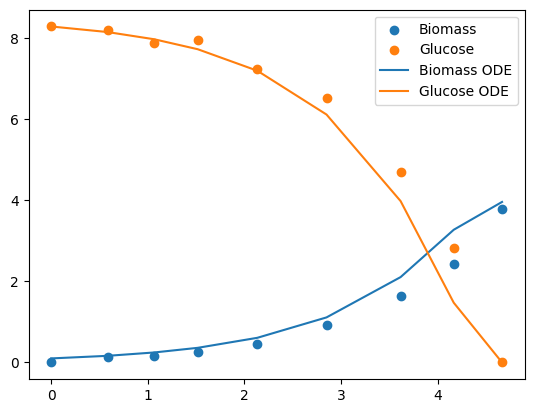

In [6]:
from scipy.integrate import odeint, solve_ivp

def ode_func(y, t, mu_max, Km, Y_XS):
    X, S = y
    mu = mu_max*S/(Km + S)
    dXdt = mu*X
    dSdt = -1/Y_XS*dXdt
    return [dXdt, dSdt]

# solve ODE
mu_max = pinn.mu_max.item()
Km = pinn.Km.item()
Y_XS = pinn.Y_XS.item()
print(f'mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

y0 = [u_train[0,0]+.1, u_train[0,1]]
sol = odeint(ode_func, y0, t_train, args=(mu_max, Km, Y_XS))

# Plot
plt.figure()
plt.scatter(t_train, u_train[:,0], label='Biomass')
plt.scatter(t_train, u_train[:,1], label='Glucose')
plt.plot(t_train, sol[:,0], label='Biomass ODE')
plt.plot(t_train, sol[:,1], label='Glucose ODE')
plt.legend()
plt.show()